In [1]:
import numpy as np
import ipywidgets as widgets
from matplotlib import pyplot as plt
from IPython.display import display, HTML

from utils import *

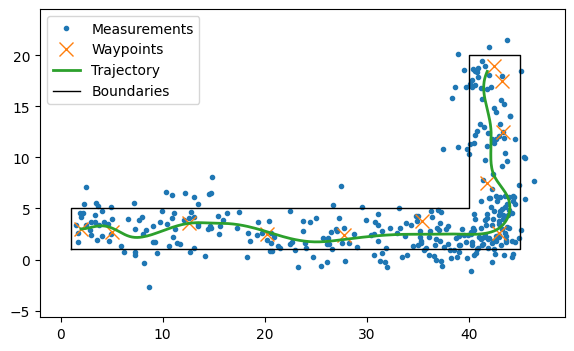

In [31]:
x_points, y_points, line_segments = track_example1()

trajectory = MPCTrajectory(x_points, y_points, line_segments, savepath="output/track_L1.pkl")
states, measurements = trajectory.get_data()

trajectory.plot()

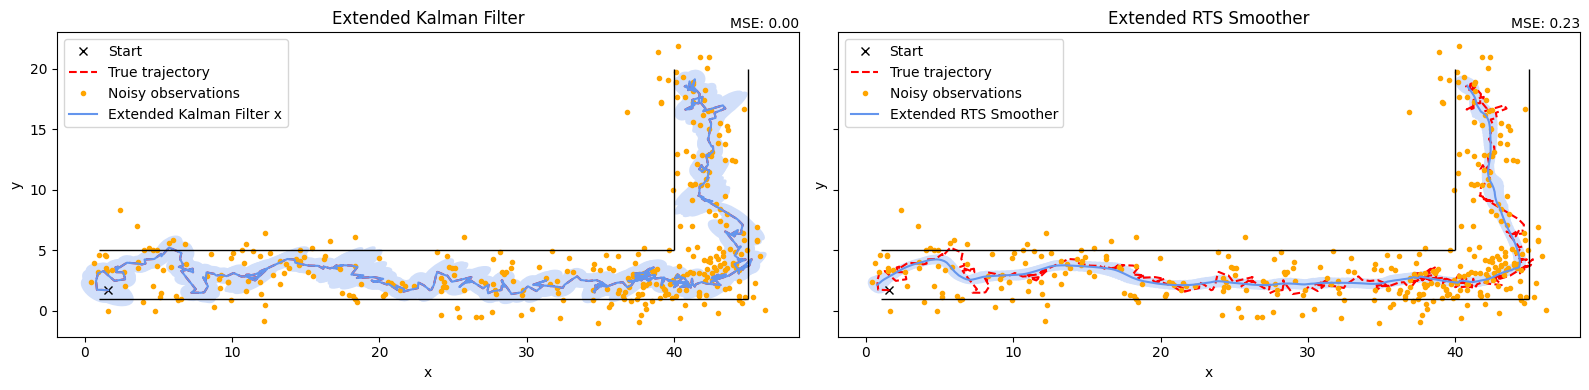

In [8]:
system = StateSpaceModel()

extendted_kalman_filter = EKF(system.f, system.F_jacobian, system.h, system.H_jacobian, system.Q, system.R)
state_estimates, cov_estimates = extendted_kalman_filter.filter(measurements)
state_estimates_smoothed, cov_estimates_smoothed = extendted_kalman_filter.smoother(state_estimates, cov_estimates)

visualize_filter_and_smoother(state_estimates, measurements, state_estimates, cov_estimates, state_estimates_smoothed, cov_estimates_smoothed, variant="Extended")

In [9]:
def sample_from_mixture(means, covariances, weights, num_samples):
    """
    Generate samples from a mixture of Gaussians.

    Parameters:
        means (list of numpy arrays): Mean vectors of the Gaussians.
        covariances (list of numpy arrays): Covariance matrices of the Gaussians.
        weights (list of floats): Mixing weights of the Gaussians.
        num_samples (int): Number of samples to generate.

    Returns:
        numpy array: Generated samples.
    """
    num_gaussians = len(means)
    samples = np.zeros((num_samples, len(means[0])))

    for i in range(num_samples):
        # Select a Gaussian component based on the mixing weights
        gaussian_index = np.random.choice(range(num_gaussians), p=weights)

        # Generate a sample from the selected Gaussian component
        sample = np.random.multivariate_normal(means[gaussian_index], covariances[gaussian_index])
        samples[i] = sample

    return samples

def parzen_resampling(weights, particles, particle_covs):

    new_particles = sample_from_mixture(particles, particle_covs, weights, len(weights))

    dim_m = 4
    new_particle_covs = np.tile(np.eye(dim_m) / 10, (len(weights), 1, 1))

    new_weights = np.ones(len(weights)) / len(weights)

    return new_weights, new_particles, new_particle_covs
   

In [10]:
class PPF:
    """
    Parzen Particle Filter (PPF) class. Provides methods for prediction, update, filtering, resampling and smoothing of a non-linear system.
    """

    def __init__(self, f, h, F_jacobian, Q, R, dim_m=4, dim_y=2, N=50):
        """
        Initialize PPF object with given parameters.

        Args:
        f (function): Function for state transition.
        F_jacobian (function): Function to compute the Jacobian of f.
        h (function): Function for measurement.
        dim_m (int): Dimension of the state. Default is 4.
        dim_y (int): Dimension of the output. Default is 2.
        N (int): Number of particles. Default is 50.
        """
        self.f = f
        self.h = h
        self.F_jacobian = F_jacobian
        self.Q = Q
        self.R = R
        self.dim_m = dim_m
        self.dim_y = dim_y
        self.N = N


    def predict(self, particles, particle_covs, weights):
        """
        Perform prediction step in Parzen Particle Filter.

        Args:
        particles (numpy.ndarray): Current particle state_estimates.
        particle_covs (numpy.ndarray): Current particle covariance matrices.
        weights (numpy.ndarray): Current weights.

        Returns:
        particles (numpy.ndarray): Predicted particle state_estimates.
        particle_covs (numpy.ndarray): Predicted particle covariance matrices.
        weights (numpy.ndarray): Predicted weights.
        """
        for i, particle in enumerate(particles):
            particles[i] = mvn(self.f(particle), particle_covs[i]).rvs() 
            particle_covs[i] = self.F_jacobian(particle) @ particle_covs[i] @ self.F_jacobian(particle).T # (7.b) from Parzen paper

        return particles, particle_covs, weights

    def update(self, y, particles, particle_covs, weights):
        """
        Perform update step in Parzen Particle Filter.

        Args:
        y (numpy.ndarray): Measurement vector.
        particles (numpy.ndarray): Current particle state_estimates.
        particle_covs (numpy.ndarray): Current particle covariance matrices.
        weights (numpy.ndarray): Current weights.

        Returns:
        particles (numpy.ndarray): Updated particle state_estimates.
        particle_covs (numpy.ndarray): Updated particle covariance matrices.
        weights (numpy.ndarray): Updated weights.
        """
        for i, (weight, particle) in enumerate(zip(weights, particles)):
            weights[i] *= mvn(self.h(particle), self.R).pdf(y) * (np.linalg.det(self.F_jacobian(particle)) ** -1)

        weights /= np.sum(weights)

        return particles, particle_covs, weights
    
    def filter(self, measurements, m=None, P=None, verbose=True):#resampling_method='systematic', ):
        """
        Perform Parzen Particle Filtering on a sequence of measurements.
        """
        if m is None: m = np.zeros(self.dim_m)
        if P is None: P = np.eye(self.dim_m) / 10

        n = len(measurements)
        state_estimates = np.empty((n, self.dim_m))
        cov_estimates = np.empty((n, self.dim_m, self.dim_m))
        particle_history = np.empty((n, self.N, self.dim_m))
        particle_cov_history = np.empty((n, self.N, self.dim_m, self.dim_m))
        weights_history = np.empty((n, self.N))

        # Draw N samples from the prior
        particles = mvn(m, P).rvs(self.N)
        particle_covs = np.tile(P, (self.N, 1, 1))
        weights = np.ones(self.N) / self.N

        if verbose:
            iterator = tqdm(enumerate(measurements), total=n)
        else:
            iterator = enumerate(measurements)

        for k, y in iterator:
            particles, particle_covs, weights = self.predict(particles, particle_covs, weights)
            particles, particle_covs, weights = self.update(y, particles, particle_covs, weights)

            m = np.average(particles, weights=weights, axis=0)
            P = np.sum([weights[i] * np.outer(particles[i] - m, particles[i] - m)
                        for i in range(self.N)], axis=0)

            state_estimates[k] = m
            cov_estimates[k] = P
            particle_history[k] = particles
            particle_cov_history[k] = particle_covs
            weights_history[k] = weights

            weights, particles, particle_covs  = parzen_resampling(weights, particles, particle_covs)

        return state_estimates, cov_estimates, particle_history, particle_cov_history, weights_history
    

  0%|          | 0/340 [00:00<?, ?it/s]

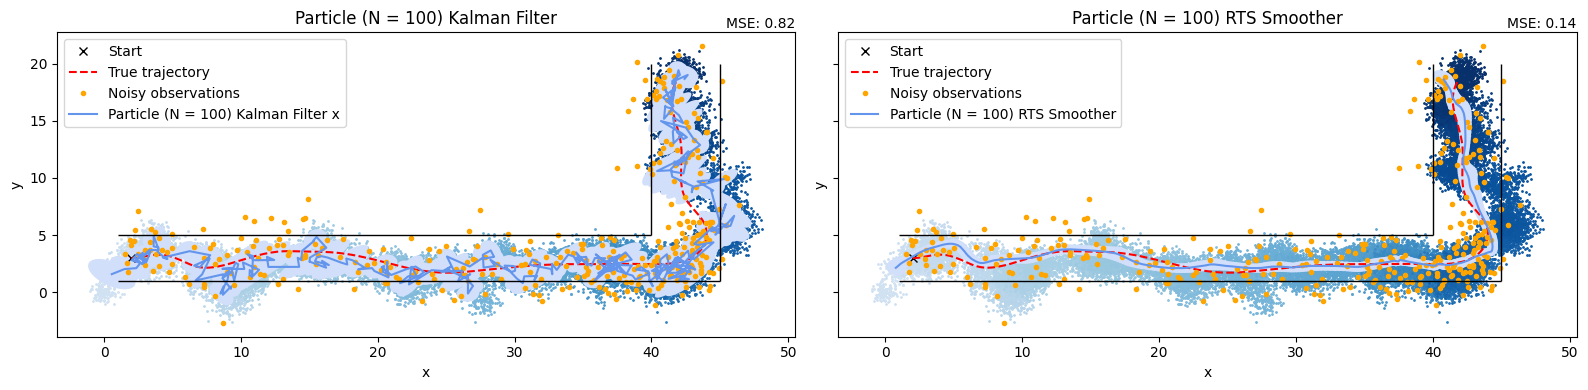

In [32]:
N = 100

parzen_particle_filter = PPF(system.f, system.h, system.F_jacobian, system.Q, system.R, N = N)
state_estimates, _, particle_history, particle_cov_history, weights_history = parzen_particle_filter.filter(measurements, verbose=True)
#state_estimates_smoothed, cov_estimates_smoothed = parzen_particle_filter.smoother(state_estimates, cov_estimates)

visualize_filter_and_smoother(states, measurements, state_estimates, cov_estimates, state_estimates_smoothed, cov_estimates_smoothed, particle_history, variant=f"Particle (N = {N})")

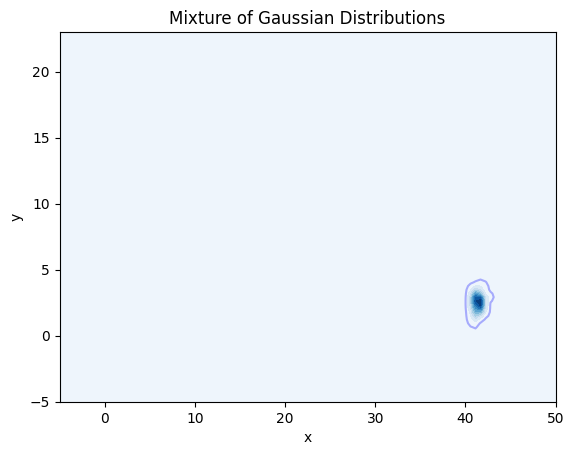

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

# Generate grid points
x = np.linspace(-5, 50, 100)
y = np.linspace(-5, 23, 100)
X, Y = np.meshgrid(x, y)
pos = np.dstack((X, Y))

idx =206

pdf = sum([multivariate_normal.pdf(pos, mean=mean[:2], cov=cov[:2, :2]) for mean, cov in zip(particle_history[idx], particle_cov_history[idx])])

# Plot the mixture distribution
#plt.figure(facecolor='white')  # Set the background color to white
plt.contour(X, Y, pdf, [.95], colors='b', alpha=0.3)  # Display only contour lines
plt.contourf(X, Y, pdf, levels=10, cmap='Blues')  # Display only contour lines
plt.xlabel('x')
plt.ylabel('y')
plt.title('Mixture of Gaussian Distributions')
#plt.colorbar(contour)  # Add a color legend based on the contour lines
plt.show()


In [36]:
class PlotParzenAnimation:

    def __init__(self, states, measurements, state_estimates, particle_history, particle_cov_history, name="animation"):
        self.states = states
        self.measurements = measurements
        self.state_estimates = state_estimates
        self.particle_history = particle_history
        self.particle_cov_history = particle_cov_history
        self.name = name

        self.fig = plt.figure(figsize=(16, 6))
        self.gs = self.fig.add_gridspec(
            2, 2, width_ratios=(4, 1), height_ratios=(1, 4),
            left=0.1, right=0.9, bottom=0.1, top=0.9,
            wspace=0.05, hspace=0.05
        )

        self.ax = self.fig.add_subplot(self.gs[1, 0])
        self.ax.plot(states[0, 0], states[0, 1], 'x', color='k', label="Start")
        self.ax.plot(states[:, 0], states[:, 1], '--', color='r', label="True trajectory")

        self.filter_points, = self.ax.plot([], [], '.', color='orange',label="Noisy observations (original)")

        self.ax.hlines(1, 1, 45, color='k', linestyle='solid', linewidth=1)
        self.ax.hlines(5, 1, 40, color='k', linestyle='solid', linewidth=1)
        self.ax.vlines(45, 1, 20, color='k', linestyle='solid', linewidth=1)
        self.ax.vlines(40, 5, 20, color='k', linestyle='solid', linewidth=1)

        self.ax_histx = self.fig.add_subplot(self.gs[0, 0], sharex=self.ax)
        self.ax_histy = self.fig.add_subplot(self.gs[1, 1], sharey=self.ax)
        self.line, = self.ax.plot([], [], '-', color='black', label="Estimated trajectory")
        self.mse_text = self.fig.text(0.75, 0.75, '', transform=self.fig.transFigure, fontsize=12)

        self.ax_histx.tick_params(axis="x", labelbottom=False)
        self.ax_histy.tick_params(axis="y", labelleft=False)

        self.contourf = None

    def update_trajectory(self, frame):
        self.line.set_xdata(self.state_estimates[:frame, 0])
        self.line.set_ydata(self.state_estimates[:frame, 1])

        if frame > 0:
            mse = np.mean((self.states[:frame, :2] - self.state_estimates[:frame, :2]) ** 2)
            self.mse_text.set_text(f'MSE: {mse:.2f}')

    def update_histogram(self, frame):
        self.ax_histx.clear()
        self.ax_histy.clear()
        self.ax_histx.set_ylim(0, .5)
        self.ax_histy.set_xlim(0, .5)

        x = np.linspace(-5, 50, 100)

        pdf = sum([norm.pdf(x, loc=mean[0], scale=np.sqrt(cov[0, 0])) for mean, cov in zip(self.particle_history[frame], self.particle_cov_history[frame])]) 
        pdf = pdf / np.sum(pdf)

        self.ax_histx.plot(x, pdf)

        pdf = sum([norm.pdf(x, loc=mean[1], scale=np.sqrt(cov[1, 1])) for mean, cov in zip(particle_history[frame], particle_cov_history[frame])])
        pdf = pdf / np.sum(pdf) + np.mean(pdf)

        self.ax_histy.plot(x, pdf)

    def init(self):
        self.ax.set_xlim(int(np.min(self.measurements[:, 0]) - 5), int(np.max(self.measurements[:, 0] + 5)))
        self.ax.set_ylim(int(np.min(self.measurements[:, 1]) - 5), int(np.max(self.measurements[:, 1] + 5)))
        self.ax_histx.set_ylim(0, .5)
        self.ax_histy.set_xlim(0, .5)
        return self.ax,

    def update_filter(self, frame):
                
        X, Y = np.meshgrid(np.linspace(-5, 50, 100), np.linspace(-5, 50, 100))
        pos = np.empty(X.shape + (2,))
        pos[:, :, 0] = X
        pos[:, :, 1] = Y

        pdf = sum([multivariate_normal.pdf(pos, mean=mean[:2], cov=cov[:2, :2]) for mean, cov in zip(self.particle_history[frame], self.particle_cov_history[frame])])

        self.contourf = self.ax.contourf(X, Y, pdf, levels=10, cmap='Blues')


        self.update_trajectory(frame)
        self.update_histogram(frame)

        self.filter_points.set_data(self.measurements[:frame, 0], self.measurements[:frame, 1])
        
        return self.ax,


    def update(self, frame):
        
        ax = self.update_filter(frame)

        return ax,

    def animate(self):
        with tqdm(total=len(self.state_estimates)) as pbar:
            ani = animation.FuncAnimation(
                self.fig, self.update, frames=range(0, len(self.state_estimates)), init_func=self.init
            )
            ani.save(f'{self.name}.gif', writer='Pillow', fps=5, progress_callback=lambda i, n: pbar.update())

        plt.close()

In [37]:
# take every 10th state
#measurements = measurements[::10]
#state_estimates = state_estimates[::10]
#particle_history = particle_history[::10]
#particle_cov_history = particle_cov_history[::10]



parzen_animation = PlotParzenAnimation(states, measurements, state_estimates, particle_history, particle_cov_history, name="animations/parzen_filter")

parzen_animation.animate()

  0%|          | 0/34 [00:00<?, ?it/s]

MovieWriter Pillow unavailable; using Pillow instead.
